<a href="https://colab.research.google.com/github/Kush-Singh-26/Neural-Style-Transfer/blob/main/Neural_Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
from torchvision import transforms as T, models
from PIL import Image
import matplotlib.pyplot as plt
import torch.optim as optim
import numpy as np

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
model = models.vgg19(weights=models.VGG19_Weights.DEFAULT).features.to(device).eval()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:08<00:00, 71.2MB/s]


In [4]:
def image_loader(img_path, size=512, device=torch.device("cpu")):
    # VGG19 mean and std
    normalize = T.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])
    loader = T.Compose([
        T.Resize(size),
        T.CenterCrop(size), # Ensure square shape after resize if aspect ratio changed
        T.ToTensor(),
        normalize,
    ])

    image = Image.open(img_path).convert('RGB') # Ensure RGB
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

In [5]:
def im_convert(tensor):
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze(0) # Remove batch dimension
    image = image.transpose(1, 2, 0) # Transpose C, H, W -> H, W, C
    # De-normalize
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1) # Clip values to be between 0 and 1
    return image

In [6]:
def gram_matrix(tensor):
    b, c, h, w = tensor.size()

    # Reshape features: (b, c, h, w) -> (c, h*w)
    features = tensor.view(c, h * w)
    # Calculate gram matrix: features * features^T
    gram = features.mm(features.t())

    return gram.div(c * h * w)

In [7]:
class ContentLossStorage(nn.Module):
    def __init__(self, target):
        super().__init__()
        # detach the target from the computation graph
        self.target = target.detach()

class StyleLossStorage(nn.Module):
    def __init__(self, target_feature):
        super().__init__()
        # Pre-calculate and detach the target gram matrix
        self.target = gram_matrix(target_feature).detach()

In [8]:
print(model)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [9]:
def get_features(image, model, layers=None):
    """ Run an image forward through a model and get the features for
        specified layers. Default layers are for VGGNet matching Content/Style Loss layers.
    """
    if layers is None:
        # Default layers for VGG19 feature extraction
        # Corresponds roughly to conv1_1, conv2_1, conv3_1, conv4_1, conv5_1
        # And conv4_2 for content
        layers = {'0': 'conv1_1',   # Style
                  '5': 'conv2_1',   # Style
                  '10': 'conv3_1',  # Style
                  '19': 'conv4_1',  # Style
                  '21': 'conv4_2',  # Content <---- VGG19
                  '28': 'conv5_1'}  # Style

    features = {}
    x = image
    for name, layer in model.named_children(): # Iterate through direct children
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
    return features

# --- Layer Definitions ---

# conv1_1: 0, relu1_1: 1, conv1_2: 2, relu1_2: 3, pool1: 4
# conv2_1: 5, relu2_1: 6, conv2_2: 7, relu2_2: 8, pool2: 9
# conv3_1: 10, relu3_1: 11, conv3_2: 12, relu3_2: 13, conv3_3: 14, relu3_3: 15, conv3_4: 16, relu3_4: 17, pool3: 18
# conv4_1: 19, relu4_1: 20, conv4_2: 21, relu4_2: 22, conv4_3: 23, relu4_3: 24, conv4_4: 25, relu4_4: 26, pool4: 27
# conv5_1: 28, relu5_1: 29, conv5_2: 30, relu5_2: 31, conv5_3: 32, relu5_3: 33, conv5_4: 34, relu5_4: 35, pool5: 36

# Choose layers based on descriptive names
content_layers_names = ['conv4_2']
style_layers_names = ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1']

# Map names back to indices needed for get_features layer selection
layer_name_to_index = {
    'conv1_1': '0', 'conv2_1': '5', 'conv3_1': '10', 'conv4_1': '19', 'conv4_2': '21', 'conv5_1': '28'
}

content_layers_indices = {layer_name_to_index[name] for name in content_layers_names}
style_layers_indices = {layer_name_to_index[name] for name in style_layers_names}
all_feature_layers_indices = content_layers_indices.union(style_layers_indices)

# Map indices to descriptive names for feature dictionary keys
layers_for_feature_extraction = {idx: name for name, idx in layer_name_to_index.items() if idx in all_feature_layers_indices}


In [10]:
content_img_path = '/content/image.png'
style_img_path = '/content/style.png'

In [11]:
imsize = 512

In [12]:
content_img = image_loader(content_img_path, size=imsize,device=device)
style_img = image_loader(style_img_path, size=imsize, device=device)

In [13]:
generated_img = content_img.clone().requires_grad_(True).to(device)

In [14]:
content_features = get_features(content_img, model, layers=layers_for_feature_extraction)
style_features = get_features(style_img, model, layers=layers_for_feature_extraction)

In [15]:
content_loss_modules = {}
for layer_name in content_layers_names:
    target = content_features[layer_name]
    content_loss_modules[layer_name] = ContentLossStorage(target)
    print(f"Content target stored for {layer_name}")

style_loss_modules = {}
for layer_name in style_layers_names:
    target_feature = style_features[layer_name]
    style_loss_modules[layer_name] = StyleLossStorage(target_feature)
    print(f"Style target stored for {layer_name}")

Content target stored for conv4_2
Style target stored for conv1_1
Style target stored for conv2_1
Style target stored for conv3_1
Style target stored for conv4_1
Style target stored for conv5_1


In [16]:
optimizer = optim.Adam([generated_img], lr=0.002)

In [17]:
alpha = 1  # Content weight
beta = 1e5 # Style weight

In [18]:
epochs = 5000
print_every = 100
show_every = 500

In [19]:
loss_history= []

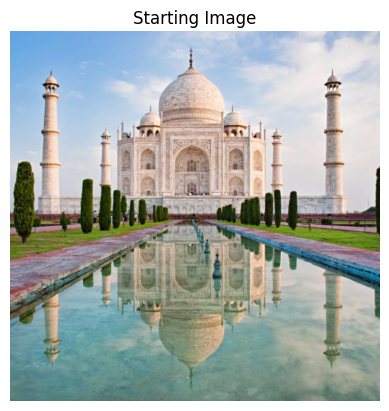

In [20]:
plt.imshow(im_convert(generated_img))
plt.title("Starting Image")
plt.axis('off')
plt.show()

Epoch 100/5000, Total Loss: 11.5864, (Weighted Content: 1.0066, Weighted Style: 10.5798)
Epoch 200/5000, Total Loss: 6.2915, (Weighted Content: 1.0125, Weighted Style: 5.2790)
Epoch 300/5000, Total Loss: 4.4483, (Weighted Content: 0.9324, Weighted Style: 3.5159)
Epoch 400/5000, Total Loss: 3.5484, (Weighted Content: 0.8536, Weighted Style: 2.6948)
Epoch 500/5000, Total Loss: 3.0114, (Weighted Content: 0.7905, Weighted Style: 2.2209)
Showing image at epoch 500


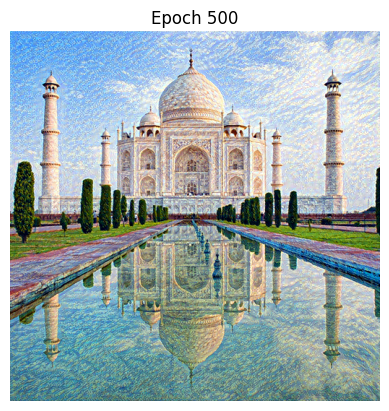

Epoch 600/5000, Total Loss: 2.6440, (Weighted Content: 0.7406, Weighted Style: 1.9034)
Epoch 700/5000, Total Loss: 2.3715, (Weighted Content: 0.7015, Weighted Style: 1.6700)
Epoch 800/5000, Total Loss: 2.1603, (Weighted Content: 0.6700, Weighted Style: 1.4903)
Epoch 900/5000, Total Loss: 1.9932, (Weighted Content: 0.6442, Weighted Style: 1.3490)
Epoch 1000/5000, Total Loss: 1.8601, (Weighted Content: 0.6231, Weighted Style: 1.2370)
Showing image at epoch 1000


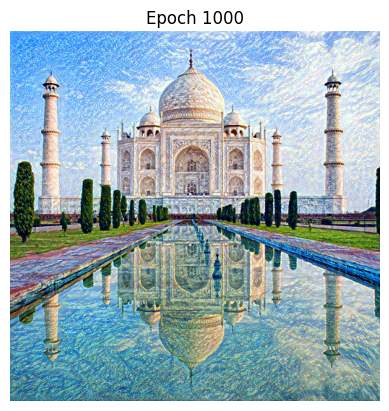

Epoch 1100/5000, Total Loss: 1.7542, (Weighted Content: 0.6044, Weighted Style: 1.1498)
Epoch 1200/5000, Total Loss: 1.6699, (Weighted Content: 0.5883, Weighted Style: 1.0817)
Epoch 1300/5000, Total Loss: 1.6025, (Weighted Content: 0.5741, Weighted Style: 1.0284)
Epoch 1400/5000, Total Loss: 1.5485, (Weighted Content: 0.5623, Weighted Style: 0.9861)
Epoch 1500/5000, Total Loss: 1.5043, (Weighted Content: 0.5522, Weighted Style: 0.9522)
Showing image at epoch 1500


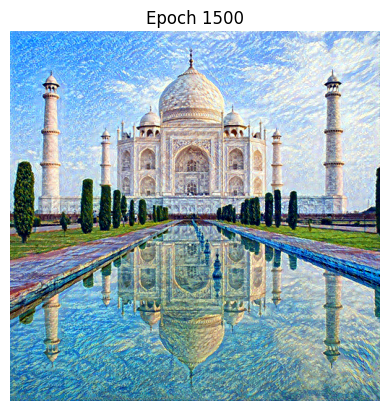

Epoch 1600/5000, Total Loss: 1.4674, (Weighted Content: 0.5430, Weighted Style: 0.9244)
Epoch 1700/5000, Total Loss: 1.4355, (Weighted Content: 0.5347, Weighted Style: 0.9008)
Epoch 1800/5000, Total Loss: 1.4076, (Weighted Content: 0.5272, Weighted Style: 0.8804)
Epoch 1900/5000, Total Loss: 1.3825, (Weighted Content: 0.5205, Weighted Style: 0.8620)
Epoch 2000/5000, Total Loss: 1.3595, (Weighted Content: 0.5141, Weighted Style: 0.8453)
Showing image at epoch 2000


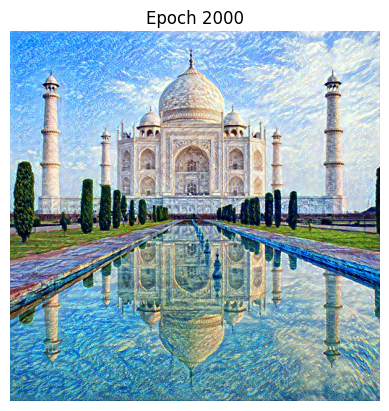

Epoch 2100/5000, Total Loss: 1.3382, (Weighted Content: 0.5085, Weighted Style: 0.8297)
Epoch 2200/5000, Total Loss: 1.3182, (Weighted Content: 0.5030, Weighted Style: 0.8153)
Epoch 2300/5000, Total Loss: 1.2994, (Weighted Content: 0.4978, Weighted Style: 0.8016)
Epoch 2400/5000, Total Loss: 1.2816, (Weighted Content: 0.4930, Weighted Style: 0.7886)
Epoch 2500/5000, Total Loss: 1.2648, (Weighted Content: 0.4884, Weighted Style: 0.7765)
Showing image at epoch 2500


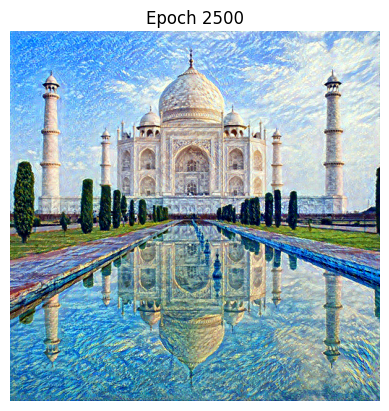

Epoch 2600/5000, Total Loss: 1.2490, (Weighted Content: 0.4841, Weighted Style: 0.7648)
Epoch 2700/5000, Total Loss: 1.2340, (Weighted Content: 0.4799, Weighted Style: 0.7540)
Epoch 2800/5000, Total Loss: 1.2196, (Weighted Content: 0.4758, Weighted Style: 0.7438)
Epoch 2900/5000, Total Loss: 1.2059, (Weighted Content: 0.4720, Weighted Style: 0.7339)
Epoch 3000/5000, Total Loss: 1.1928, (Weighted Content: 0.4684, Weighted Style: 0.7243)
Showing image at epoch 3000


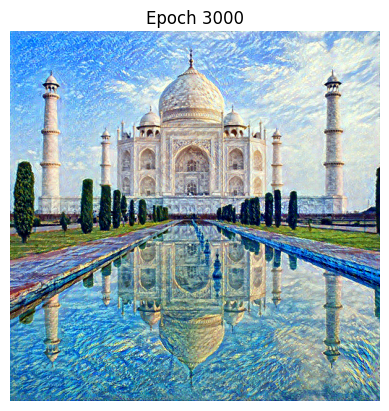

Epoch 3100/5000, Total Loss: 1.1802, (Weighted Content: 0.4649, Weighted Style: 0.7152)
Epoch 3200/5000, Total Loss: 1.1681, (Weighted Content: 0.4613, Weighted Style: 0.7069)
Epoch 3300/5000, Total Loss: 1.1566, (Weighted Content: 0.4576, Weighted Style: 0.6991)
Epoch 3400/5000, Total Loss: 1.1457, (Weighted Content: 0.4542, Weighted Style: 0.6915)
Epoch 3500/5000, Total Loss: 1.1353, (Weighted Content: 0.4507, Weighted Style: 0.6846)
Showing image at epoch 3500


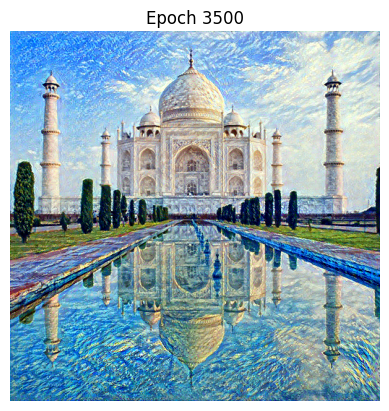

Epoch 3600/5000, Total Loss: 1.1253, (Weighted Content: 0.4476, Weighted Style: 0.6777)
Epoch 3700/5000, Total Loss: 1.1156, (Weighted Content: 0.4445, Weighted Style: 0.6711)
Epoch 3800/5000, Total Loss: 1.1063, (Weighted Content: 0.4414, Weighted Style: 0.6649)
Epoch 3900/5000, Total Loss: 1.0974, (Weighted Content: 0.4386, Weighted Style: 0.6588)
Epoch 4000/5000, Total Loss: 1.0888, (Weighted Content: 0.4358, Weighted Style: 0.6531)
Showing image at epoch 4000


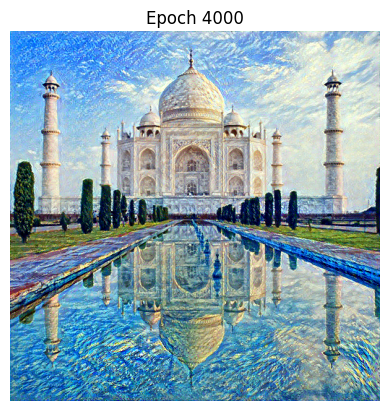

Epoch 4100/5000, Total Loss: 1.0806, (Weighted Content: 0.4329, Weighted Style: 0.6477)
Epoch 4200/5000, Total Loss: 1.0728, (Weighted Content: 0.4304, Weighted Style: 0.6424)
Epoch 4300/5000, Total Loss: 1.0655, (Weighted Content: 0.4278, Weighted Style: 0.6378)
Epoch 4400/5000, Total Loss: 1.0585, (Weighted Content: 0.4252, Weighted Style: 0.6333)
Epoch 4500/5000, Total Loss: 1.0519, (Weighted Content: 0.4228, Weighted Style: 0.6292)
Showing image at epoch 4500


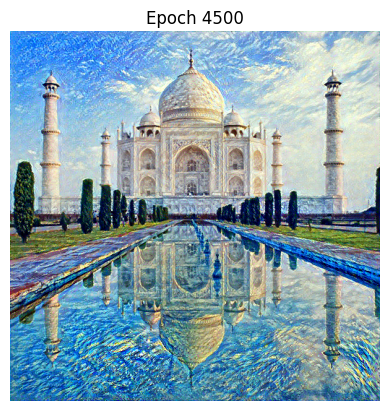

Epoch 4600/5000, Total Loss: 1.0457, (Weighted Content: 0.4205, Weighted Style: 0.6251)
Epoch 4700/5000, Total Loss: 1.0396, (Weighted Content: 0.4183, Weighted Style: 0.6213)
Epoch 4800/5000, Total Loss: 1.0339, (Weighted Content: 0.4162, Weighted Style: 0.6177)
Epoch 4900/5000, Total Loss: 1.0285, (Weighted Content: 0.4140, Weighted Style: 0.6145)
Epoch 5000/5000, Total Loss: 1.0233, (Weighted Content: 0.4121, Weighted Style: 0.6112)
Showing image at epoch 5000


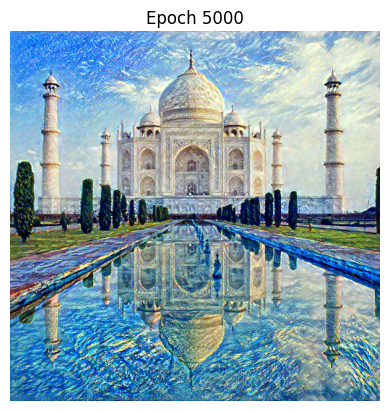

In [21]:
for epoch in range(1, epochs + 1):

    # --- Get current features ---
    generated_features = get_features(generated_img, model, layers=layers_for_feature_extraction)

    # --- Calculate Losses (Directly in loop) ---
    # Initialize loss components for this epoch
    current_content_loss = torch.tensor(0.0, device=device, requires_grad=True) # Make sure it requires grad initially if adding to it
    current_style_loss = torch.tensor(0.0, device=device, requires_grad=True)   # Make sure it requires grad initially if adding to it

    # Content Loss Calculation
    for layer_name, storage_module in content_loss_modules.items():
        # Get the target from the storage module
        target_feature = storage_module.target
        # Get the current input feature for this layer
        input_feature = generated_features[layer_name]
        # Calculate MSE loss directly - this connects to generated_img graph
        loss = nn.functional.mse_loss(input_feature, target_feature)
        current_content_loss = current_content_loss + loss # Add to the loss tensor

    # Style Loss Calculation
    style_weights = {'conv1_1': 1.0, 'conv2_1': 0.75, 'conv3_1': 0.2, 'conv4_1': 0.2, 'conv5_1': 0.2}
    for layer_name, storage_module in style_loss_modules.items():
        # Get the target gram matrix from the storage module
        target_gram = storage_module.target
        # Get the current input feature for this layer
        input_feature = generated_features[layer_name]
        # Calculate gram matrix for the current input feature
        input_gram = gram_matrix(input_feature)
        # Calculate MSE loss directly - this connects to generated_img graph
        loss = nn.functional.mse_loss(input_gram, target_gram)
        # Apply weight for this layer's style loss
        current_style_loss = current_style_loss + style_weights[layer_name] * loss


    # --- Total Weighted Loss ---
    # Ensure alpha and beta are appropriate
    # print(f"Debug: alpha={alpha}, beta={beta}") # Uncomment for debug
    # print(f"Debug: content_loss part = {current_content_loss.item()}, style_loss part = {current_style_loss.item()}") # Uncomment
    total_loss = alpha * current_content_loss + beta * current_style_loss

    # --- Optimization Step ---
    optimizer.zero_grad()

    total_loss.backward()

    optimizer.step()

    # --- Print Loss and Show Image Periodically ---
    loss_history.append(total_loss.item())
    if epoch % print_every == 0:
        print(f"Epoch {epoch}/{epochs}, "
              f"Total Loss: {total_loss.item():.4f}, "
              f"(Weighted Content: {alpha * current_content_loss.item():.4f}, "
              f"Weighted Style: {beta * current_style_loss.item():.4f})")

    if epoch % show_every == 0 or epoch == epochs: # Show on show_every or last epoch
        print(f"Showing image at epoch {epoch}")
        with torch.no_grad(): # Don't track gradients during image conversion/display
            plt.imshow(im_convert(generated_img))
            plt.title(f"Epoch {epoch}")
            plt.axis('off')
            plt.show()


Training Finished!


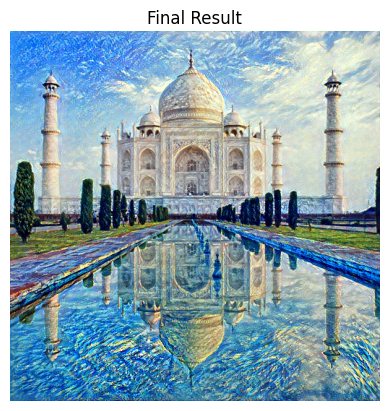

Final image saved as output_image.png


In [22]:
print("\nTraining Finished!")

plt.imshow(im_convert(generated_img))
plt.title("Final Result")
plt.axis('off')
plt.show()

# 1. Clone the final generated image tensor (which should be [1, 3, H, W])
final_tensor = generated_img.detach().cpu().clone().squeeze(0) # Remove batch dim

# 2. De-normalize the 3-channel tensor
mean = torch.tensor([0.485, 0.456, 0.406]).view(-1, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(-1, 1, 1)
final_tensor = final_tensor * std + mean

# 3. Clamp values to [0, 1] range
final_tensor = torch.clamp(final_tensor, 0, 1)

# 4. Convert the de-normalized [3, H, W] tensor to PIL Image
final_image_pil = T.ToPILImage()(final_tensor)

# 5. Save the PIL image

final_image_pil.save("output_image.png")
print("Final image saved as output_image.png")

In [23]:
# After instantiating StyleLossStorage modules (before training loop)
target_grams_to_save = {}
for layer_name, storage_module in style_loss_modules.items():
    target_grams_to_save[layer_name] = storage_module.target.cpu() # Move to CPU for saving

torch.save(target_grams_to_save, 'style_target_grams.pt')
print("Style target Gram matrices saved to style_target_grams.pt")

Style target Gram matrices saved to style_target_grams.pt


Starting inference optimization...
Step 100/500, Loss: 0.4252
Step 200/500, Loss: 0.1393
Step 300/500, Loss: 0.0824
Step 400/500, Loss: 0.0572
Step 500/500, Loss: 0.0430
Inference finished.


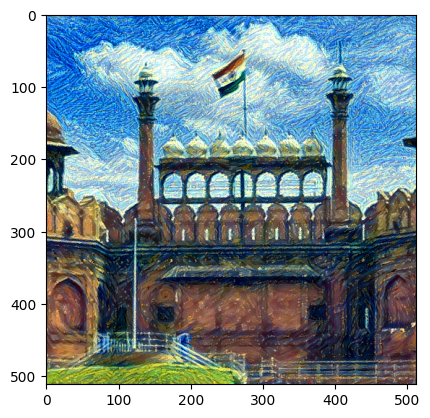

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms as T

# 1. Load the VGG model
model = models.vgg19(weights=models.VGG19_Weights.DEFAULT).features.to(device).eval()
for param in model.parameters(): param.requires_grad_(False)

# 2. Load the saved target Gram matrices
loaded_target_grams = torch.load('style_target_grams.pt')
# Move targets to the correct device for calculation
for layer_name in loaded_target_grams:
    loaded_target_grams[layer_name] = loaded_target_grams[layer_name].to(device)

# 3. Load the NEW content image
new_content_path = '/content/redfort.png'
new_content_img = image_loader(new_content_path, size=imsize, device=device)
if new_content_img is None: raise SystemExit("Failed")

# 4. Initialize the generated image (clone of NEW content)
generated_img = new_content_img.clone().requires_grad_(True).to(device)

# 5. Setup optimizer for the new generated image
lr = 0.02
optimizer = optim.Adam([generated_img], lr=lr)

# 6. Define layers needed for feature extraction (style layers only needed)
layers_for_inference = {idx: name for name, idx in layer_name_to_index.items() if name in style_layers_names}

print("Starting inference optimization...")

inference_steps = 500 # Number of optimization steps for inference
for step in range(1, inference_steps + 1):
    generated_features = get_features(generated_img, model, layers=layers_for_inference)

    current_style_loss = torch.tensor(0.0, device=device, requires_grad=True)
    for layer_name in style_layers_names: # Use the keys from loaded grams
        target_gram = loaded_target_grams[layer_name]
        input_feature = generated_features[layer_name]
        input_gram = gram_matrix(input_feature)
        loss = nn.functional.mse_loss(input_gram, target_gram)
        current_style_loss = current_style_loss + style_weights[layer_name] * loss

    total_loss = beta * current_style_loss

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    if step % 100 == 0:
        print(f"Step {step}/{inference_steps}, Loss: {total_loss.item():.4f}")

# 8. Get the final stylized image
print("Inference finished.")
plt.imshow(im_convert(generated_img))
plt.show()


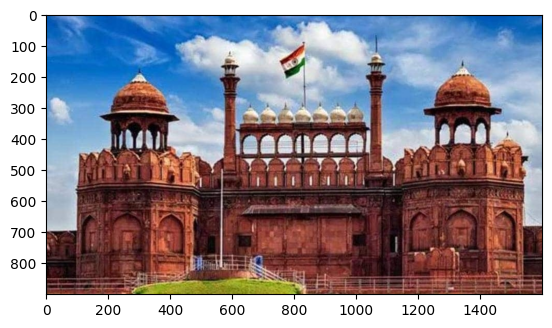

In [25]:
import matplotlib.pyplot as plt
from PIL import Image

image = Image.open('redfort.png')

# Display using Matplotlib
plt.imshow(image)
plt.show()


Training Finished!


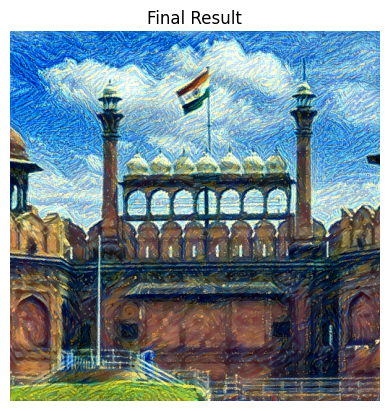

Final image saved as output_image.png


In [26]:
print("\nTraining Finished!")

plt.imshow(im_convert(generated_img))
plt.title("Final Result")
plt.axis('off')
plt.show()

# 1. Clone the final generated image tensor (which should be [1, 3, H, W])
final_tensor = generated_img.detach().cpu().clone().squeeze(0) # Remove batch dim

# 2. De-normalize the 3-channel tensor
mean = torch.tensor([0.485, 0.456, 0.406]).view(-1, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(-1, 1, 1)
final_tensor = final_tensor * std + mean

# 3. Clamp values to [0, 1] range
final_tensor = torch.clamp(final_tensor, 0, 1)

# 4. Convert the de-normalized [3, H, W] tensor to PIL Image
final_image_pil = T.ToPILImage()(final_tensor)

# 5. Save the PIL image

final_image_pil.save("output_image.png")
print("Final image saved as output_image.png")